# 5 重抽样方法
重抽样方法是现代统计学中不可缺少的工具。这种方法通过反复在训练集中抽取样本，然后对每一个样本重新拟合一个感兴趣的模型，来获取关于拟合模型的附加信息。我们讨论两种最常用的重抽样方法，**交叉验证法**（cross-validation)和**自助法**（bootstrap)。
## 5.1 交叉验证法
训练错误率通常与测试错误率有很大区别，尤其是表现为**训练错误率**可能会严重地低估**测试错误率**。在本节中，我们考虑这样一类方法：在拟合过程中，**保留**训练观测的一个子集，然后对保留的观测运用统计学习方法，从而估计其测试错误率。
### 5.1.1  验证集方法
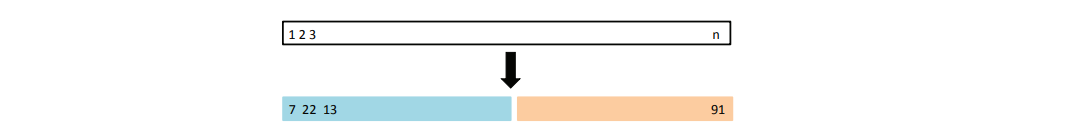
图5-1：验证集方法的原理图。一个由n个观测的集合被随机地分为一个训练集（蓝色部分，包含观测7、22、13等）和一个验证集（橙色部分，包含观测91等）。验证集方法是在训练集上拟合统计学习方法，然后在验证集上评价其表现的方法。

In [11]:
import pandas as pd
import numpy as np
import warnings

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import os
path=os.getcwd()
warnings.filterwarnings("ignore")

In [12]:
data = pd.read_csv(os.path.join(path,'data','Auto.csv'),engine='python')
print(data.shape)
data.head()

(397, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [13]:
data.dtypes  # 发现horsepower类型可疑

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
year              int64
origin            int64
name             object
dtype: object

In [14]:
data['horsepower'].unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [15]:
data['horsepower'] = data['horsepower'].replace('?',np.nan)
data = data.dropna()
data['horsepower'] = data['horsepower'].astype('int')
data.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower        int32
weight            int64
acceleration    float64
year              int64
origin            int64
name             object
dtype: object

In [16]:
# 用验证集方法预测测试误差
powers = np.arange(1,11)
errors = []

for power in powers:
    poly = PolynomialFeatures(power)  # 1-10次项（进行特征的构造）
    X = poly.fit_transform(data['horsepower'].to_frame())  # 拟合+标准化
    y = data['mpg']
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state = 0)#划分训练集、测试数据
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    errors.append(mean_squared_error(y_test,lr.predict(X_test)))

In [25]:
x = np.arange(6).reshape(3,2) # 原始特征：[a,b]
x

array([[0, 1],
       [2, 3],
       [4, 5]])

In [26]:
poly = PolynomialFeatures(degree=2)  # 构造二阶多项式得到新特征：[1, a, b, a^2, b^2, a*b]
res = poly.fit_transform(x)
res 

array([[ 1.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  2.,  3.,  4.,  6.,  9.],
       [ 1.,  4.,  5., 16., 20., 25.]])

Text(0.5, 1, 'Validation Set')

<Figure size 864x432 with 0 Axes>

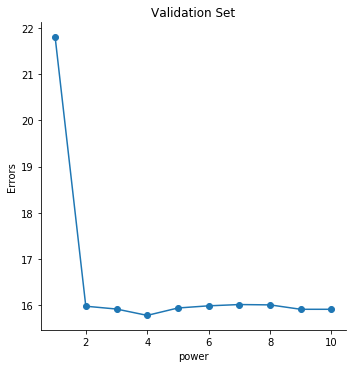

In [17]:
temp = pd.DataFrame({"power":powers,'Errors':errors})
plt.figure(figsize = (12,6))
g = sns.FacetGrid(data = temp,size=5)
g.map(plt.scatter, 'power' , 'Errors')
g.map(plt.plot, 'power', 'Errors')
plt.title('Validation Set')

In [18]:
errors_list = []
for i in range(10):  # 运用十次验证集方法
    errors = []
    for power in powers:
        poly = PolynomialFeatures(power)
        X = poly.fit_transform(data['horsepower'].to_frame())
        y = data['mpg']
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state = i)

        lr = LinearRegression()
        lr.fit(X_train,y_train)
        errors.append(mean_squared_error(y_test,lr.predict(X_test)))#y和预测集比较
    errors_list.append(errors)  

In [19]:
data_dict = {'Errors'+ str(i):errors_list[i] for i in range(10)}
temp = pd.DataFrame(data_dict)
temp.index = powers

In [20]:
temp.head()

,Errors0,Errors1,Errors2,Errors3,Errors4,Errors5,Errors6,Errors7,Errors8,Errors9
1,21.811143,25.650160,28.827536,24.301369,19.272390,27.642677,23.776677,19.308620,21.060574,19.866369
2,15.977120,17.264520,23.742558,16.833850,13.476055,24.596552,17.410193,16.455937,12.453263,15.961779
3,15.915739,17.108497,23.604935,16.904634,13.398018,24.738484,17.722400,17.946887,12.251760,15.760263
4,15.778294,16.927266,24.277251,17.061203,13.286756,24.676498,18.807723,17.703585,12.478693,16.198389
5,15.938348,16.824453,25.036717,16.354698,12.552333,24.498935,16.656960,15.593667,12.468997,15.313392


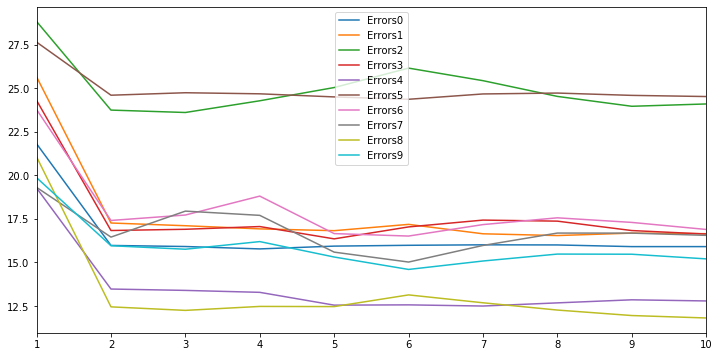

In [121]:
temp.plot.line(figsize = (12,6))

验证集方法的原理很简单，且易于执行。但它有两个潜在的缺陷：  
1.如上图所示，测试错误率的验证法估计的波动很大，这取决于具体哪些观测被包括在训练集中，哪些观测被包括在验证集中。  
2.在验证法中，只有一部分观测——那些被包含在训练集而非验证集中的观测——被用于拟合模型。由于被训练的观测越少，统计方法表现越不好，这意味着，验证集错误率可能会高估在整个数据集上拟合模型所得的的测试错误率。

### 5.1.2  留—交叉验证法
不同于把观测集分为两个大小相当的子集, 留一交叉验证法（LOOCV）将一个单独的观测 $(x_1, y_1)$ 作为验证集，剩下的观测 ${(x_2, y_2),...,(x_n, y_n)}$ 组成训练集。然后在 $n−1$ 个训练观测上拟合统计学习方法，再对余下的观测根据它的值 $x_1$ 来做 $\hat{y}_1$ 。  
$$MSE_1 = {(y_1−\hat{y}_1)}^2\tag{5.1}$$  
$${CV}_{(n)}=\frac{1}{n}\sum_{i=1}^n MSE_i\tag{5.2}$$                                      
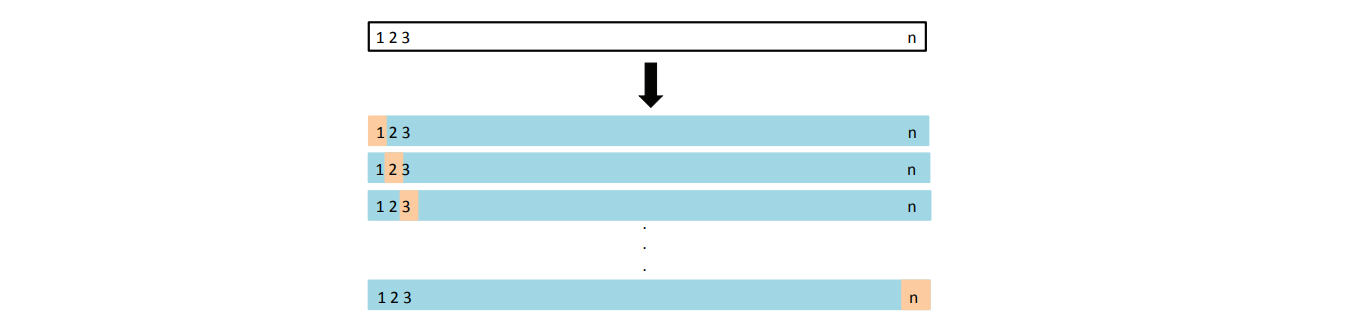
图5-3：LOOCV的原理图。一个有 $n$ 个数据点的集合被反复地分割为一个训练集，包含除了一个观测之外的全部观测（图中蓝色部分），以及一个验证集，只包含剩下的那个观测（图中橙色部分）。测试误差通过对 $n$ 个所得到的均方误差求平均来估计。第一个训练集包含除了观测1之外的全部观测，第二个训练集包含除了观测2之外的全部观测，以此类推。  
$${CV}_{(n)}=\frac{1}{n}\sum_{i=1}^n (\frac{y_i−\hat{y}_i}{1-h_i})^2\tag{5.3}$$  
$$h_i=\frac{1}{n}+\frac{(x_i-\overline{x})^2}{\sum_{i'=1}^n (x_{i'}-\overline{x})^2}\tag{5.4}$$

In [122]:
from sklearn.model_selection import cross_val_score  # 交叉验证
scores = []
n = len(data)
for power in range(1,11):
    poly = PolynomialFeatures(power,include_bias=False)  # 无偏置项
    X = poly.fit_transform(data['horsepower'].to_frame())
    y = data['mpg']
    lr = LinearRegression()
    scores.append(cross_val_score(lr,X,y,cv = n,scoring = 'neg_mean_squared_error').mean())  # 计算n次抽样的MSE的均值

In [125]:
scores = list(map(abs,scores))  # 画图前对MSE取绝对值
powers = np.arange(1,11)

(15, 28)

<Figure size 864x432 with 0 Axes>

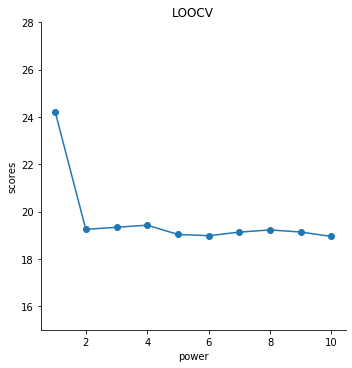

In [124]:
temp = pd.DataFrame({"power":powers,'scores':scores})
plt.figure(figsize = (12,6))
g = sns.FacetGrid(data = temp,size=5)
g.map(plt.scatter, 'power' , 'scores')
g.map(plt.plot, 'power', 'scores')
plt.title('LOOCV')
plt.ylim(15,28)

In [126]:
# 运用十次10折CV方法（每次把数据分割为10份）
scores_list = []
from sklearn.utils import shuffle
for _ in range(10):
    scores = []
    n = len(data)
    for power in range(1,11):
        poly = PolynomialFeatures(power,include_bias=False)
        X = poly.fit_transform(data['horsepower'].to_frame())
        y = data['mpg']
        X,y = shuffle(X,y)
        lr = LinearRegression()
        scores.append(cross_val_score(lr,X,y,cv = 10,scoring = 'neg_mean_squared_error').mean())
    scores_list.append(list(map(abs,scores)))    

In [127]:
data_dict = {'Scores'+ str(i):scores_list[i] for i in range(10)}
temp = pd.DataFrame(data_dict)
temp.index = powers

In [128]:
temp.head()

,Scores0,Scores1,Scores2,Scores3,Scores4,Scores5,Scores6,Scores7,Scores8,Scores9
1,24.167637,24.291972,24.148133,24.172336,24.232714,24.196155,24.073534,24.259928,24.335211,24.195384
2,19.194600,19.437383,19.273673,19.368687,19.263213,19.183521,19.109656,19.274410,19.179943,19.245990
3,19.286124,19.532901,19.239187,19.392336,19.367022,19.421853,19.307620,19.470141,19.359738,19.458295
4,19.365670,19.471980,19.400953,19.380081,19.537017,19.283844,19.376267,19.337048,19.348732,19.299870
5,19.183790,19.148723,18.916748,19.014523,19.336075,19.469855,19.249826,18.968914,18.982326,19.211874


Text(0, 0.5, 'Error')

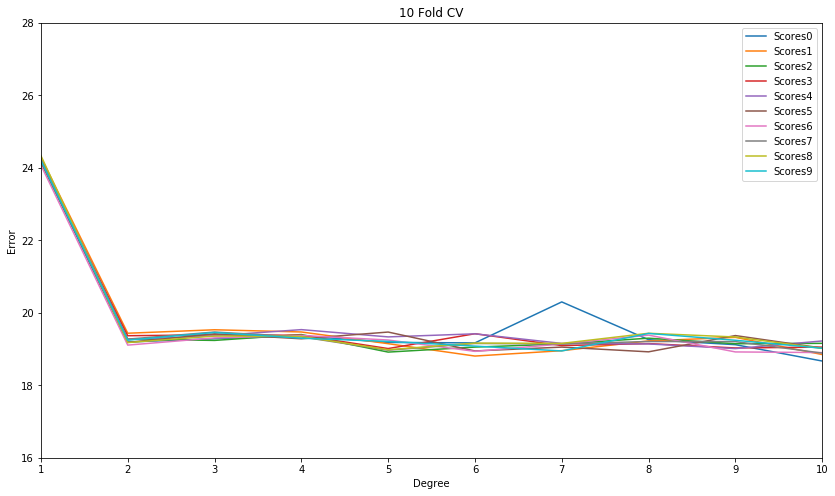

In [129]:
temp.plot.line(figsize = (14,8))
plt.ylim(16,28)
plt.title('10 Fold CV')
plt.xlabel('Degree')
plt.ylabel('Error')

### 5.1.3 k折交叉验证法
这种方法将测试集随机地分为 $k$ 个大小基本一致的组，或者说**折**（fold）。第一折作为验证集，然后在剩下的 $k-1$ 折上拟合模型。均方误差 $MSE_1$ 由保留折的观测计算得出。重复这个步骤 $k$ 次，每一次把不同的观测组作为验证集。整个过程会得到 $K$ 个测试误差的估计， $MSE_1，MSE_1，\dots, MSE_k$ 。$k$折$CV$估计由这些值求平均得到：
$${CV}_{(k)}=\frac{1}{n}\sum_{i=1}^k MSE_i\tag{5.5}$$  
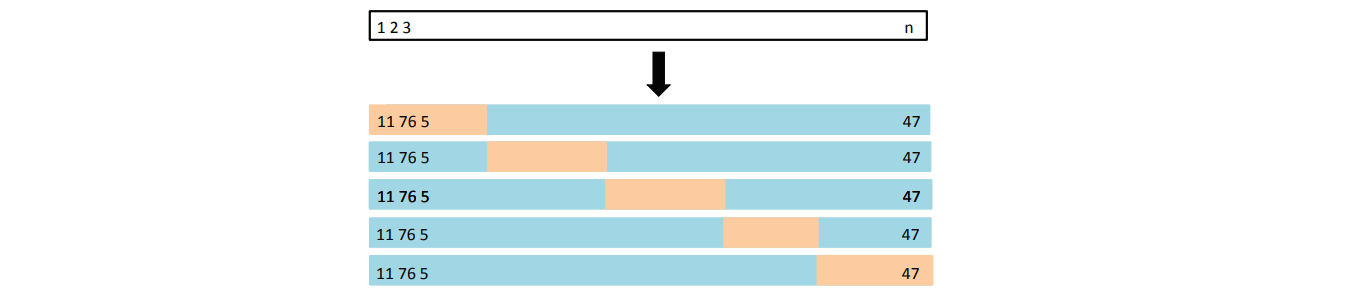  
图5-5：五折CV方法的原理图。一个有$n$个观测的集合被随机地分为5个不重叠的组。每一个组轮流作为验证集（图中橙色部分），剩下的组作为训练集（图中蓝色部分）。测试误差通过对5个所得到的均方误差估计求平均来估计。

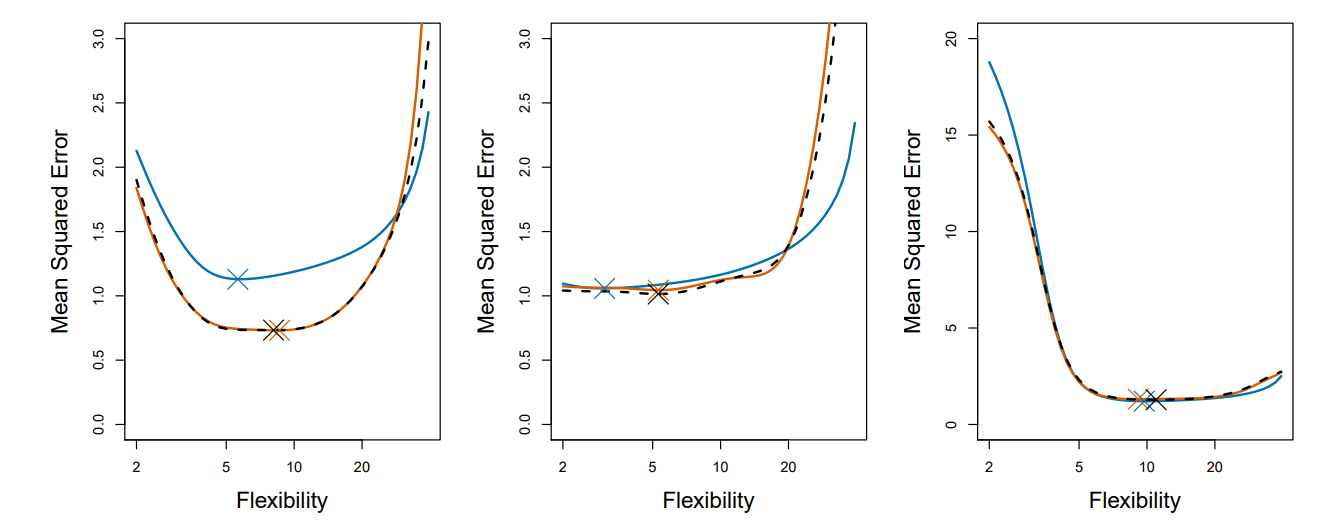  
图5-6：三个模拟数据集的测试均方误差的真值和估计值。蓝色实线为测试均方误差的真值，黑色虚线为LOOCV估计值，橙色实线为10折$CV$估计值。用“x”标注的点表示每条均方误差曲线的最小值点。

### 5.1.4 K折交叉验证的偏差-方差权衡
用k折CV方法，比如令 $k = 5$ 或 $k = 10$，则会产生一个中等程度的偏差，因为每个训练集包括$(k − 1)n/k$ 个观测——比LOOCV方法少，但比验证集方法多得多。因此，从较小偏差的角度考虑，显然LOOCV方法比K折CV方法更好。  
但是，在估计过程中，偏差并不是唯一需要考虑的问题，估计量的方差也是需要考虑的问题。而当$k<n$时，LOOCV方法的方差要比k折CV方法更好。  
### 5.1.5 交叉验证在分类问题中的应用
分类问题背景下，LOOCV方法的错误率的形式为：  
$${CV}_{n)}=\frac{1}{n}\sum_{i=1}^k Err_i, Err_i=I(y_i\ne\hat{y}_i)\tag{5.6}$$   
对二维分类数据，可以拟合多个逻辑斯蒂模型（以二次为例）：
$$\log(\frac{p}{1-p})=\beta_0+\beta_1X_1+\beta_2X^2_1+\beta_3X_2+\beta_4X^2_2\tag{5.7}$$

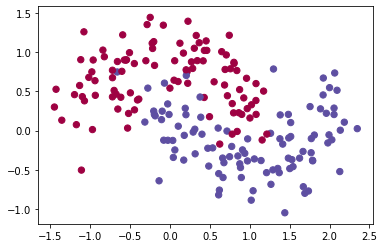

In [131]:
import sklearn
from sklearn import *
np.random.seed(0)
# 解释变量X是连续变量,如（-1.2，-0.5）；响应变量y是分类变量：0/1
X, y = sklearn.datasets.make_moons(200, noise=0.25)  # 加入高斯噪声
plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

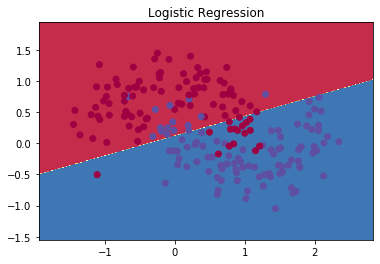

In [46]:
def plot_decision_boundary(pred_func):
    """
    :param pred_func: function
    :return: plot
    """
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))  # 生成网格点坐标矩阵
 
    # 用传入的预测函数进行预测
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])  # 连接x,y
    Z = Z.reshape(xx.shape)
 
    # 分界+布点
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

    
from sklearn.linear_model import LogisticRegressionCV

# 训练逻辑回归分类器
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)
 
# 绘制决策边界
plot_decision_boundary(lambda x: clf.predict(x))  # 用lambda表达式:将函数作为实参传入自定义函数
plt.title("Logistic Regression")
plt.show()

In [134]:
powers = np.arange(1,11)
import statsmodels.api as sm
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score 

# 用预测变量的多项式做逻辑斯蒂回归
errors_list = []
scores_list = []
accuracy_train_list = []
for power in powers:
    np.random.seed(0)
    X, y = sklearn.datasets.make_moons(200, noise=0.25)
    poly = PolynomialFeatures(power,include_bias=False)#1-10次项
    X = poly.fit_transform(X)
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state = 0)#划分训练、测试数据，random_state为0时每次结果不同
    clf = sklearn.linear_model.LogisticRegressionCV()
    clf.fit(X_train, y_train)
    
    # 三个指标衡量该回归的表现
    errors = []
    errors.append(accuracy_score(y_test,clf.predict(X_test)))#测试错误率
    errors_list.append(errors) 
    
    accuracy_train = []
    accuracy_train = accuracy_score(y_train,clf.predict(X_train))#训练错误率
    accuracy_train_list.append(accuracy_train)
    
    score = []
    score = cross_val_score(clf,X,y,scoring='accuracy',cv = 10).mean()#10折CV错误率
    scores_list.append(score)

Text(0, 0.5, 'accuracy')

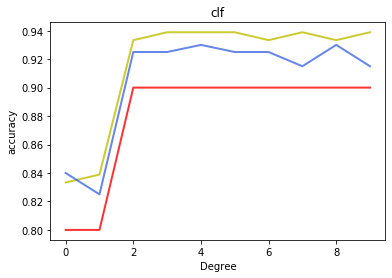

In [135]:
plt.plot( range(10),errors_list, color='r', alpha=0.8, linewidth=2)
plt.plot( range(10),accuracy_train_list, color='y', alpha=0.8, linewidth=2)
plt.plot( range(10),scores_list, color='#4169E1', alpha=0.8, linewidth=2)
plt.title('clf')
plt.xlabel('Degree')
plt.ylabel('accuracy')

In [140]:
from sklearn.neighbors import KNeighborsClassifier

# KNN分类器在不同K值下的分类表现
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.25)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state = 0)

scores_list = []
accuracy_test_list = []
accuracy_train_list = []

for n in range(1,51):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train,y_train)
    
    accuracy_test = []
    accuracy_test = accuracy_score(y_test,knn.predict(X_test))#测试错误率
    accuracy_test_list.append(accuracy_test)
    
    accuracy_train = []
    accuracy_train = accuracy_score(y_train,knn.predict(X_train))#训练错误率
    accuracy_train_list.append(accuracy_train)
    
    score = []
    score = cross_val_score(knn,X,y,scoring='accuracy',cv = 10).mean()#10折CV错误率
    scores_list.append(score)

Text(0, 0.5, 'accuracy')

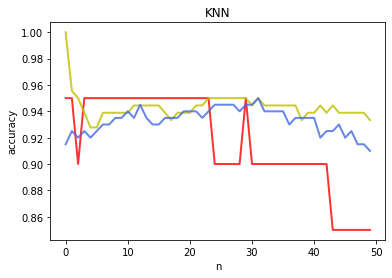

In [141]:
plt.plot( range(50),accuracy_test_list, color='r', alpha=0.8, linewidth=2)   # 红色：测试错误率
plt.plot( range(50),accuracy_train_list, color='y', alpha=0.8, linewidth=2   # 黄色：训练错误率
plt.plot( range(50),scores_list, color='#4169E1', alpha=0.8, linewidth=2)    # 蓝色：10折CV错误率
plt.title('KNN')
plt.xlabel('n')
plt.ylabel('accuracy')

## 5.2 自助法（bootstrap)
自助法的强大体现在它可以简便地应用到很多统计学习方法中取，其中包括一些对波动性的测量指标要么很难获得，要么不会由统计软件自动输出的方法。  
示例：我们希望能够确定一个简单模型下最优的资产分配。把所有钱百分比为$\alpha$的部分投资到资产X，百分比为$1-\alpha$的部分投资到资产Y。希望选择一个$\alpha$,使得投资的总风险$Var(\alpha X+(1-\alpha)Y)$最小。使得风险最小的$\alpha$为：  
$$\alpha=\frac{\sigma^2_Y-\sigma_XY}{\sigma^2_X+\sigma^2_Y-2\sigma_XY}\tag{5.8}$$  
可以使用包含过去X，Y值的数据集计算这些量的估计值 $\sigma^2_X=Var(X),\sigma^2_Y=Var(Y),2\sigma_{XY}=Cov(X,Y)$，即可估计投资方差最小的$\alpha$：
$$\alpha=\frac{\hat\sigma^2_Y-\hat\sigma_{XY}}{\hat\sigma^2_X+\hat\sigma^2_Y-2\hat\sigma_{XY}}\tag{5.9}$$

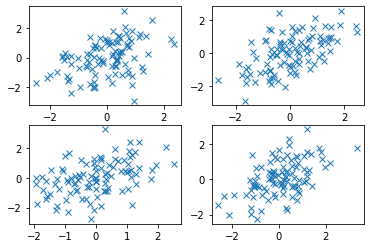

In [51]:
# 模拟生成投资收益X,Y

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

X = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1.25]], 100)
ax1.plot(X[:, 0], X[:, 1], 'x')
X = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1.25]], 100)
ax2.plot(X[:, 0], X[:, 1], 'x')
X = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1.25]], 100)
ax3.plot(X[:, 0], X[:, 1], 'x')
X = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1.25]], 100)
ax4.plot(X[:, 0], X[:, 1], 'x')

In [142]:
# 计算1,000 个 𝛼 估计的均值
a_list = []
for _ in range(1000):
    X = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1.25]], 100)  # 模拟生成数据，α=0.6
    a = (np.var(X[:, 1])-np.cov(X[:, 0],X[:, 1]))/(np.var(X[:, 0])+np.var(X[:, 1])-2*np.cov(X[:, 0],X[:, 1]))
    a = a[:, 1][0]    
    a_list.append(a)
a_mean = np.mean(a_list)
a_mean

0.5999729537180624

In [53]:
a_deviation = np.std(a_list, ddof = 1)  # 设置成无偏的
a_deviation

0.07984966713200377

1,000 个 $\alpha $ 估计的均值为：  
$$\overline{\alpha }=\frac{1}{1,000}\sum_{r=1}^{1,000} \hat\alpha _r=0.5999\tag{5.10}$$
这接近真值 $\alpha  = 0.6$, 估计量的标准差为：
$$ \sqrt {\frac{1}{1,000-1}\sum_{r=1}^{1,000} (\hat\alpha _r-\overline{\alpha })^2}=0.079\tag{5.11}$$
这样对$\hat\alpha$的精度有一个很好的认识： $SE(\hat\alpha)\approx0.079$。所以大致上说，对于总体的一个随机样本，可以认为平均上 $\hat\alpha $ 跟 $\alpha $ 的差距大致为 0.079。

自助法可以用电脑来模拟得到新的样本集这一个过程，从而可以估计$\hat\alpha$的波动性而不用生成额外的样本。
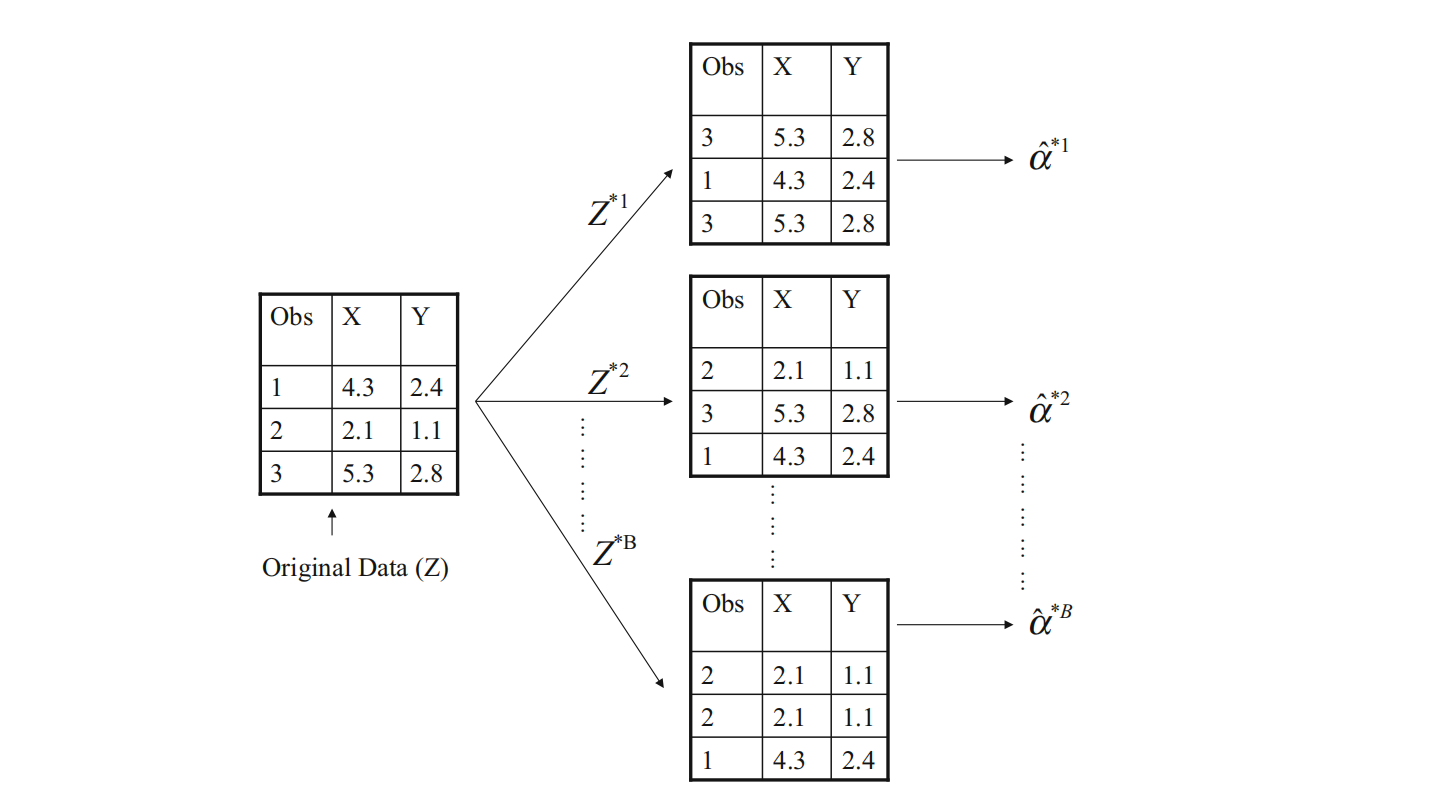

In [54]:
# bootstrap抽样计算 𝛼
from random import choices
ab_list = []
X = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1.25]], 100)
for _ in range(1000):
    x = choices(X[:, 0], k=100)##无放回抽样
    y = choices(X[:, 1], k=100)
    ab = (np.var(y)-np.cov(x,y))/(np.var(x)+np.var(y)-2*np.cov(x,y))
    ab = ab[:, 1][0]    
    ab_list.append(ab)
ab_mean = np.mean(ab_list)
ab_mean

0.6248695009555694

In [55]:
# 评估通过bootstrap法计算 𝛼 的精度
ab_deviation = np.std(ab_list, ddof = 1)##设置成无偏的
ab_deviation

0.0423531392494144

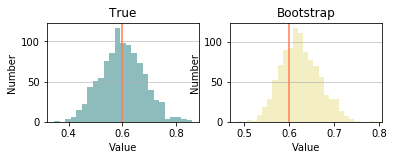

In [56]:
# 比较“用真实总体生成1000个模拟数据集”和“bootstap法”算得𝛼的波动性
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
n, bins, patches =plt.hist(x=a_list, bins='auto', color='cadetblue',alpha=0.7, rwidth=10)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Number')
plt.title('True')
plt.axvline(0.6,c="coral")

ax2 = fig.add_subplot(2,2,2)
n, bins, patches =plt.hist(x=ab_list, bins='auto', color='palegoldenrod',alpha=0.7, rwidth=10)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Number')
plt.title('Bootstrap')
plt.axvline(0.6,c="coral")


Text(0, 0.5, 'Value')

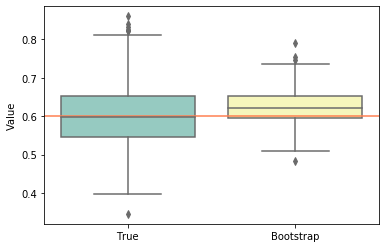

In [57]:
data =pd.DataFrame ({'True':a_list,'Bootstrap':ab_list})
sns.boxplot(data=data.iloc[:,0:2],palette="Set3")
plt.axhline(0.6,c="coral")
plt.ylabel('Value')

## 5.3 实验：交叉验证法和自助法(bootstrap)

### 5.3.1 验证集方法
为了估计在Auto数据集上拟合多个线性模型所产生的测试错误率，现在研究验证集方法的使用。  
在开始之前，用random_state参数来为Python的随机生成器设置种子，读者可以得到与书本展示相同的结果。  
首先用sample()函数把测试集分为两半，从原始的392个观测中随机选取一个有196个观测的子集，作为训练集。

In [58]:
import statsmodels.api as sm
import random
import pandas as pd 
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score  ##交叉验证
import warnings
warnings.filterwarnings("ignore")

In [60]:
Auto = pd.read_csv('Auto.csv')
Auto['horsepower'] = Auto['horsepower'].replace('?', np.nan).astype(float)
Auto = Auto.dropna()
Auto.shape

(392, 9)

In [61]:
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [63]:
def get_error(data,power,seed):
    """
    power:多项式的最高幂次
    seed:随机种子数值
    """
    n = len(data)
    poly = PolynomialFeatures(power,include_bias=False)
    horsepower = poly.fit_transform(Auto['horsepower'].to_frame())
    mpg=Auto['mpg']
    X_train,X_test,y_train,y_test = train_test_split(horsepower,mpg,test_size = 0.5,random_state = seed)
    ols = sm.OLS(y_train,sm.add_constant(X_train),missing='drop').fit() # Drop the missing value
    y_predict= ols.predict(sm.add_constant(X_test))
    return mean_squared_error(y_test,y_predict)   ##计算均方误差

In [64]:
get_error(Auto,1,0)  ##一元一次回归，随机种子为0

23.616617069669882

In [65]:
get_error(Auto,2,0)  ##一元二次回归，随机种子为0

18.763031346897094

In [66]:
get_error(Auto,3,0)  ##一元三次回归，随机种子为0

18.796941632643136

In [67]:
get_error(Auto,1,1)  ##一元一次回归，随机种子为1

24.80212062059357

In [68]:
get_error(Auto,2,1)  ##一元二次回归，随机种子为1

18.848292603275333

In [12]:
get_error(Auto,3,1)  ##一元三次回归，随机种子为1

18.805111358391517

* 结果与之前的结论一致：一个用horsepower的二次函数来拟合的模型预测mpg的效果比仅用horsepower的线性函数拟合模型的效果要好，而几乎没有证据表明用horsepower的三次函数拟合模型的效果更好。

### 5.3.2 留一交叉验证法

*  我们可以使用sm.formula.glm()函数和sm.OLS()自动计算任何广义线性模型的估计量，但sm.formula.glm()和sm.OLS()不能进行交叉验证。因此可以将LinearRegression()和cross_val_score()结合起来进行交叉验证。

In [69]:
# 用OLS回归
ols = sm.OLS(mpg,sm.add_constant(horsepower),missing='drop').fit()  # Drop the missing value
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Fri, 05 Nov 2021   Prob (F-statistic):           7.03e-81
Time:                        17:59:04   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
# 用广义线性回归
glm=sm.formula.glm("mpg~ horsepower", data=Auto).fit()
glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mpg   No. Observations:                  392
Model:                            GLM   Df Residuals:                      390
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          24.066
Method:                          IRLS   Log-Likelihood:                -1178.7
Date:                Fri, 05 Nov 2021   Deviance:                       9385.9
Time:                        17:59:08   Pearson chi2:                 9.39e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.000      38.530      41.342
horsepower    -0.1578      0.006    -24.489      0.000      -0.170      -0.145
==============================================================================
"""

In [71]:
scores = []
n = len(Auto)  #n为交叉验证的折数，此处留一交叉验证中n为样本数量
for power in range(1,6):
    poly = PolynomialFeatures(power,include_bias=False)
    X = poly.fit_transform(Auto['horsepower'].to_frame())
    y = Auto['mpg']
    lr = LinearRegression()
    scores.append(-cross_val_score(lr,X,y,cv = n,scoring = 'neg_mean_squared_error').mean())
print('均方误差的均值：')
scores

均方误差的均值：


[24.231513517929226,
 19.248213124489677,
 19.334984064029175,
 19.424430310525526,
 19.033212804000605]

### 5.3.3 k折交叉验证法
*  cross_val_score（）函数也可用于实现k折叠CV。下面我们在自动数据集上使用k=10，这是k的一个常见选择。

In [73]:
##k=10
random.seed(17)
scores = []
for power in range(1,11):
    poly = PolynomialFeatures(power,include_bias=False)
    X = poly.fit_transform(Auto['horsepower'].to_frame())
    y = Auto['mpg']
    lr = LinearRegression()
    scores.append(-cross_val_score(lr,X,y,cv = 10,scoring = 'neg_mean_squared_error').mean())
scores

[27.439933652339867,
 21.23584005580223,
 21.336606183227314,
 21.353886981375947,
 20.905640766798655,
 20.780115397193125,
 20.96809437795243,
 21.07765383909865,
 21.0376023762478,
 20.973329158269884]

### 5.3.4 自助法（bootstrap)
本节通过5.2节中的简单例子，还有一个估计在Auto数据集上拟合线性回归模型的精度的例子，来说明自助法的使用。

* 估计一个感兴趣的统计量的精度。
* 示例：我们希望在一个简单模型下确定最佳资产分配。实现风险$Var(\alpha X+(1-\alpha)Y)$最小。  
其中 $\sigma^2_X=Var(X),\sigma^2_Y=Var(Y),2\sigma_{XY}=Cov(X,Y)$
$$\alpha=\frac{\hat\sigma^2_Y-\hat\sigma_{XY}}{\hat\sigma^2_X+\hat\sigma^2_Y-2\hat\sigma_{XY}}\tag{5.9}$$

In [74]:
portfolio=pd.read_csv('portfolio.csv',index_col=0)
portfolio.head()

,X,Y
1,-0.895251,-0.234924
2,-1.562454,-0.885176
3,-0.417090,0.271888
4,1.044356,-0.734198
5,-0.315568,0.841983


In [75]:
#风险最小时的alpha
def get_alpha(data,index):
    x=data.iloc[index,0]
    y=data.iloc[index,1]
    alpha=(np.cov(y)-np.cov(x,y))/(np.cov(x)+np.cov(y)-2*np.cov(x,y))
    return alpha[0,1]  

In [76]:
get_alpha(portfolio,list(range(100)))   ##基于全样本计算的风险最小时的alpha

0.57583207459283

In [77]:
#进行一次随机抽样，风险最小时的alpha
np.random.seed(0)
index=np.random.choice(range(100),100,replace=True) 
get_alpha(portfolio,index)

0.5596158281037941

In [78]:
#进行1000次随机抽样，风险最小时的alpha
alpha_list=[]
for _ in range(1000):
    index=np.random.choice(range(100),100,replace=True) 
    alpha=get_alpha(portfolio,index)
    alpha_list.append(alpha)
alpha_est=np.mean(alpha_list)    
alpha_deviation = np.std(alpha_list, ddof = 1)##设置成无偏的
print('alpha:',alpha_est,'估计误差:',alpha_deviation)

alpha: 0.5795622652632741 估计误差: 0.08878472522902055


* 估计回归模型的精度
* bootstrap方法可用于评估统计学习方法中系数估计和预测的可变性。在这里我们使用bootstrap方法来评估$\beta$0和$\beta$1的估计值，即使用horsepower预测自动数据集中mpg的线性回归模型的截距和斜率项。

In [79]:
#计算回归系数
def get_params(data,Y,X,index):
    glm=sm.formula.glm(Y+"~"+X, data=data.iloc[index,]).fit()
    params=glm.params
    return params

In [80]:
get_params(Auto,"mpg","horsepower",list(range(392)))  ##全样本的线性回归

Intercept     39.935861
horsepower    -0.157845
dtype: float64

In [81]:
random.seed(1)
index=np.random.choice(range(392),392,replace=True)
get_params(Auto,"mpg","horsepower",index)     ##一次随机抽样的线性回归

Intercept     40.239109
horsepower    -0.161896
dtype: float64

In [82]:
#采用bootstrap方法估计回归系数及估计误差
def boot(data,Y,X,R):
    """
    Y：因变量名
    X:自变量名
    R：重抽样次数
    """
    params_list=[]
    for _ in range(R):
        index=np.random.choice(range(392),392,replace=True)
        params=get_params(Auto,Y,X,index)
        params_list.append(params)
    param=np.stack(params_list)
    return "回归系数：{params}, 估计误差: {error}".format(params=np.mean(param,axis=0), error=np.std(param,axis=0, ddof = 1))

In [83]:
boot(Auto,"mpg","horsepower",1000)    ##1000次随机抽样的线性回归

'回归系数：[39.98975742 -0.15839916], 估计误差: [0.85804183 0.00739665]'

In [84]:
glm=sm.formula.glm("mpg~ horsepower", data=Auto.iloc[0:392,]).fit()
glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mpg   No. Observations:                  392
Model:                            GLM   Df Residuals:                      390
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          24.066
Method:                          IRLS   Log-Likelihood:                -1178.7
Date:                Fri, 05 Nov 2021   Deviance:                       9385.9
Time:                        18:10:49   Pearson chi2:                 9.39e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.000      38.530      41.342
horsepower    -0.1578      0.006    -24.489      0.000      -0.170      -0.145
==============================================================================
"""

* 标准误差估计值与使用bootstrap得到的估计值有些区别。标准公式假定$x_i$（有点不现实）是固定的，所有的波动性都是由误差$\varepsilon_i$的波动产生的。  
* bootstrap方法不依赖于这些假设，所以它相对summary（）函数，对$\hat{\beta}_0, \hat{\beta}_1$的标准误差的估计结果更加准确。

In [85]:
Auto['horsepower2']=Auto['horsepower']**2
res=boot(Auto,"mpg","horsepower+horsepower2",1000)
res

'回归系数：[ 5.68512711e+01 -4.65629034e-01  1.22927989e-03], 估计误差: [2.11333039e+00 3.36656163e-02 1.21347073e-04]'

In [86]:
glm2=sm.formula.glm("mpg~ horsepower+horsepower2", data=Auto.iloc[0:392,]).fit()
glm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mpg   No. Observations:                  392
Model:                            GLM   Df Residuals:                      389
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          19.131
Method:                          IRLS   Log-Likelihood:                -1133.2
Date:                Fri, 05 Nov 2021   Deviance:                       7442.0
Time:                        18:11:40   Pearson chi2:                 7.44e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      56.9001      1.800     31.604      0.000      53.371      60.429
horsepower     -0.4662      0.031    -14.978      0.000      -0.527      -0.405
horsepower2     0.0012      0.000     10.080      0.000       0.001       0.001
===============================================================================
"""

#### 注意：python中的np.var()与R中的var()计算方式有差异：
* python中的np.var()计算的是总体方差，分母是n
* R中的var()计算的是样本方差，分母是n-1
* python中的np.cov(x)计算的是样本方差，分母是n-1
####  python中np.cov(x,y)与R中np.cov(x,y)返回值不同：
* python中np.cov(x,y)，返回协方差矩阵
* R中np.cov(x,y)，返回协方差

In [91]:
x=portfolio['X']
y=portfolio['Y']
np.var(x)   #计算的是总体方差，分母是n

1.1173559345375694

In [92]:
np.mean((x-np.mean(x))**2)

1.1173559345375694

In [93]:
np.cov(x)  #np.cov(x)计算的是样本方差，分母是n-1

array(1.12864236)

In [94]:
sum((x-np.mean(x))**2)/(len(x)-1)

1.128642358118757

In [95]:
np.cov(x[:],y[:])   #python中np.cov(x,y)，返回协方差矩阵

array([[1.12864236, 0.62635829],
       [0.62635829, 1.30823747]])